In [1]:
import numpy as np
from astropy.io import ascii
import glob
import os
from astropy.stats import biweight_location, biweight_scale

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
%matplotlib inline

# update matplotlib params for bigger font
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'mathtext.fontset': 'stix',
         'font.family': 'STIXGeneral'}
pylab.rcParams.update(params)

import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.37, Om0=0.3147)

In [2]:
spec_files = glob.glob("core_spectra_unflagged/*.tab")
len(spec_files)

759

In [3]:
lae_info = ascii.read("lae_info.tab")
lae_info["redshift"] = lae_info["wl_com"]/1215.67 - 1

In [4]:
linewidths = ascii.read('linewidths.tab')

In [5]:
tmp1, tmp2 = [], []
for i in range(len(lae_info)):
    lae = lae_info[i]
    lae_0 = linewidths[(linewidths["field"]==lae['field'])&(linewidths["ifu"] == int(lae["ifu"]))&(linewidths["id"]==lae["id"])]
    tmp1.append(lae_0['linewidth'])
    tmp2.append(lae_0['wavelength'])

lae_info['linewidth'] = tmp1
lae_info['new_wave'] = tmp2

In [6]:
lae_info['luminosity'] = 4 * np.pi * lae_info["flux"] * (cosmo.luminosity_distance(lae_info["redshift"]).to(u.cm)/u.cm)**2

In [7]:
c = 3*10**5 # km/s
lae_info["linewidth_kms"] = c * lae_info["linewidth"] / lae_info["new_wave"]

# plot LAE sample distribution

In [122]:
sources = lae_info.copy()

In [123]:
def log10(x):
    return np.log(x)/np.log(10)

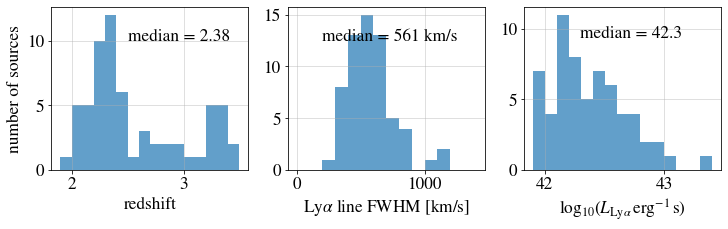

In [147]:
fig = plt.figure(figsize=(12,3))
alpha=0.7

X, Y = 200, 12.5
ax1 = fig.add_subplot(132)
bins = np.arange(0, 1500, 100)
ax1.hist(sources["linewidth_kms"]*2.35, bins=bins, alpha=alpha, label="SFGs")
ax1.set_xlabel(r"Ly$\alpha$ line FWHM [km/s]")
ax1.text(X, Y, "median = {:.0f} km/s".format(np.nanmedian(sources["linewidth_kms"]*2.35)), fontsize='xx-large')
#ax1.text(X, Y - DIFF, "median = {:.0f} km/s".format(np.nanmedian(sources["linewidth_kms"][agn_sample * sn_mask]*2.35)), color='orangered', fontsize='xx-large')

ax2 = fig.add_subplot(133)
X, Y = 42.3, 9.4
bins = np.arange(log10(8e41), log10(3e43),0.1)
ax2.hist(log10(sources["luminosity"]), bins=bins, alpha=alpha)
ax2.set_xlabel(r"$\mathrm{log}_{10}(L_{\mathrm{Ly}\alpha}\,\mathrm{erg}^{-1}\,\mathrm{s})$")
ax2.text(X, Y, "median = {:.1f}".format(np.nanmedian(log10(sources["luminosity"]))), fontsize='xx-large')
#ax2.text(X, Y - DIFF, "median = {:.1f}".format(np.nanmedian(log10(sources["luminosity"][agn_sample * sn_mask]))), color='orangered', fontsize='xx-large')

ax3 = fig.add_subplot(131)
bins = np.arange(1.9, 3.6, 0.1)
X, Y = 2.5, 10
ax3.hist(sources["redshift"], bins=bins, alpha=alpha)
ax3.text(X, Y, "median = {:.2f}".format(np.nanmedian(sources["redshift"])), fontsize='xx-large')
#ax3.text(X, Y - DIFF, "median = {:.2f}".format(np.nanmedian(sources["redshift"][agn_sample * sn_mask])), color='orangered', fontsize='xx-large')
ax3.set_xlabel("redshift")
ax3.set_ylabel("number of sources")


if False:
    ax5 = fig.add_subplot(235)
    bins = np.arange(22, 35, 1)
    ax5.hist(sources["gmag"][sfg_sample * sn_mask], bins=bins, alpha=alpha)
    ax5.hist(sources["gmag"][agn_sample * sn_mask], bins=bins, alpha=alpha)
    ax5.set_xlabel("g-band magnitude")

    ax6 = fig.add_subplot(236)
    bins = np.arange(-3, 3, 0.2)
    ax6.hist(sources["continuum"][sfg_sample * sn_mask], bins=bins, alpha=alpha)
    ax6.hist(sources["continuum"][agn_sample * sn_mask], bins=bins, alpha=alpha)
    ax6.set_xlabel(r"continuum [$10^{-17}\,\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,(2\AA)^{-1}$]")

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(alpha=0.5)
    
#fig.savefig(os.path.join('thesis_plots',"gama_lae_sample.pdf"), bbox_inches="tight")

In [130]:
min(sources['linewidth_kms'])*2.35, max(sources['linewidth_kms'])*2.35

(array([269.85670559]), array([1448.09597884]))

# plot average rest-frame spectrum

In [8]:
def_wave = np.arange(3470, 5542, 2)
min_bins = np.arange(800, 1900, 2/(np.nanmax(lae_info["redshift"] + 1)))

In [9]:
min_bins

array([ 800.        ,  800.44475705,  800.88951409, ..., 1898.99466037,
       1899.43941742, 1899.88417446])

In [10]:
big_dict = {}
for appendix in ["0_2", "2_5", "5_10","0_2_m", "2_5_m", "5_10_m"]:
    big_dict[appendix] = []
    
i=0
for fin in spec_files:    
    tmp = ascii.read(fin)
    for appendix in ["0_2", "2_5", "5_10", "0_2_m", "2_5_m", "5_10_m"]:
        tab = np.interp(min_bins, tmp["rest_wave"], tmp["spec_"+appendix])
        big_dict[appendix].append(tab)
    i+=1
    if i % 100 == 0:
        print("Done with", i)

Done with 100
Done with 200
Done with 300
Done with 400
Done with 500
Done with 600
Done with 700


In [11]:
redshift_factors = []
for fin in spec_files:
    field, ifu, ID = fin.split("_")[-3:]
    field = field.split("/")[-1]
    ID = ID[:-4]
    ifu, ID = int(ifu), int(ID)
    lae = lae_info[(lae_info["field"]==field)*(lae_info["ifu"]==ifu)*(lae_info["id"]==ID)]
    
    redshift = lae["redshift"][0]
    redshift_factors.append(0.5 * (1+redshift)**2)
redshift_factors = np.array(redshift_factors)

In [12]:
median_spec = {}
err_spec = {}

for appendix in ["0_2", "2_5", "5_10", "0_2_m", "2_5_m", "5_10_m"]:
    big_dict[appendix] = np.array(big_dict[appendix])
    median_spec[appendix] = np.nanmedian((big_dict[appendix].T ).T, axis=0) # * redshift_factors
    
    ones = np.ones(np.shape(big_dict[appendix]))
    ones[~np.isfinite(big_dict[appendix])] = 0
    N = np.nansum(ones, axis=0)
    
    err_spec[appendix] = biweight_scale((big_dict[appendix].T).T, axis=0, ignore_nan=True) #* redshift_factors

/home/idies/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


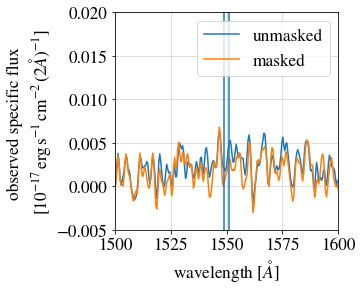

In [15]:
plt.figure(figsize=(4,4))

sigma = 1
plt.plot(min_bins, gaussian_filter(median_spec["0_2"], sigma=sigma), label="unmasked")
plt.plot(min_bins, gaussian_filter(median_spec["0_2_m"], sigma=sigma), label="masked")
plt.axvline(1215.67, color="gray", linestyle=":")

plt.xlim(1150, 1300)
plt.grid(alpha=0.5)
plt.ylim(-0.005, 0.02)

plt.xlabel(r"wavelength [$\AA$]")
plt.ylabel(r"""observed specific flux 
[$10^{-17}\,\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,(2\AA)^{-1}$]""")
plt.legend()

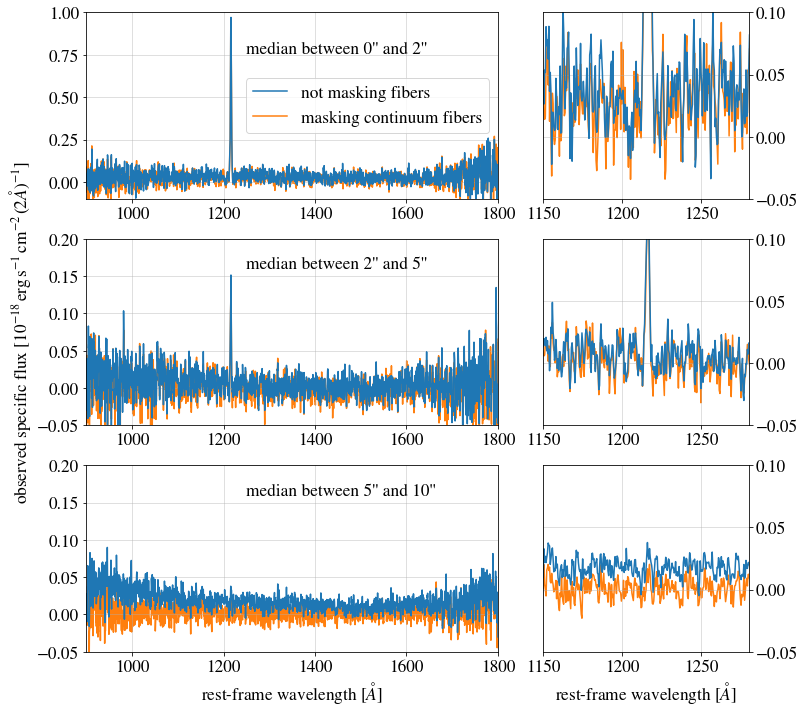

In [63]:
fig = plt.figure(figsize=(11,10))
XMIN, XMAX = 900, 1800
LMIN, LMAX = 1150, 1280

widths = [3, 1.5]
heights = [1,1,1]
spec5 = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths,
                          height_ratios=heights)


ax1, ax2, ax3 = fig.add_subplot(spec5[0,0]), fig.add_subplot(spec5[1,0]), fig.add_subplot(spec5[2,0])
for ax, appendix in zip([ax1, ax2, ax3], ["0_2", "2_5", "5_10"]):

    sigma = 0
    ax.plot(min_bins, 10*gaussian_filter(median_spec[appendix], sigma=sigma), label="not masking fibers")
    ax.plot(min_bins, 10*gaussian_filter(median_spec[appendix+"_m"], sigma=sigma), label="masking continuum fibers",
            zorder=0)

    ax.set_xlim(900, 1800)
    ax.grid(alpha=0.5)
    
ax3.set_xlabel(r"rest-frame wavelength [$\AA$]")
ax2.set_ylabel(r"observed specific flux [$10^{-18}\,\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,(2\AA)^{-1}$]")

ax1.set_ylim(-0.1, 1)
ax2.set_ylim(-0.05, 0.2)
ax3.set_ylim(-0.05, 0.2)

ax1.legend(loc='center right')

ax1.text(1250, 0.76, "median between 0'' and 2''", fontsize="xx-large")
ax2.text(1250, 0.16, "median between 2'' and 5''", fontsize="xx-large")
ax3.text(1250, 0.16, "median between 5'' and 10''", fontsize="xx-large")

ax1, ax2, ax3 = fig.add_subplot(spec5[0,1]), fig.add_subplot(spec5[1,1]), fig.add_subplot(spec5[2,1])
for ax, appendix in zip([ax1, ax2, ax3], ["0_2", "2_5", "5_10"]):

    sigma = 0
    ax.plot(min_bins, 10*gaussian_filter(median_spec[appendix], sigma=sigma), label="unmasked")
    ax.plot(min_bins, 10*gaussian_filter(median_spec[appendix+"_m"], sigma=sigma), label="masked", zorder=0)

    ax.set_xlim(1150, 1280)
    ax.grid(alpha=0.5)
    ax.yaxis.tick_right()
    
ax3.set_xlabel(r"rest-frame wavelength [$\AA$]")
ax1.set_ylim(-0.05, 0.1)
ax2.set_ylim(-0.05, 0.1)
ax3.set_ylim(-0.05, 0.1)

fig.tight_layout()

#fig.savefig('thesis_plots/average_restframe_spectra_masked_vs_unmasked.pdf', bbox_inches='tight')